In [11]:
%pip install gymnasium
%pip install gymnasium[classic-control]

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Noe\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


     --------------------------------------- 10.6/10.6 MB 43.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Noe\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [62]:
import gymnasium as gym
import numpy as np
import time
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical
import matplotlib.pyplot as plt
%matplotlib inline

In [96]:
class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

        self.batch_size = batch_size

    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return np.array(self.states), np.array(self.actions), np.array(self.probs), np.array(self.vals), np.array(self.rewards), np.array(self.dones), batches
        
    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)
        self.actions.append(action)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

In [97]:
class ActorNetwork(nn.Module):
    def __init__(self, n_actions, input_dims, alpha, fc1_dims=256, fc2_dims=256, chkpt_dir='tmp/ppo'):
        super(ActorNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'actor_torch_ppo')
        self.actor = nn.Sequential(
            nn.Linear(*input_dims, fc1_dims),
            nn.ReLU(),
            nn.Linear(fc1_dims, fc2_dims),
            nn.ReLU(),
            nn.Linear(fc2_dims, n_actions),
            nn.Softmax(dim=-1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        dist = self.actor(state)
        dist = Categorical(dist)

        return dist

    def save_checkpoint(self):
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(torch.load(self.checkpoint_file))

In [98]:
class CriticNetwork(nn.Module):
    def __init__(self, input_dims, alpha, fc1_dims=256, fc2_dims=256, chkpt_dir='tmp/ppo'):
        super(CriticNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'critic_torch_ppo')
        self.critic = nn.Sequential(
            nn.Linear(*input_dims, fc1_dims),
            nn.ReLU(),
            nn.Linear(fc1_dims, fc2_dims),
            nn.ReLU(),
            nn.Linear(fc2_dims, 1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        value = self.critic(state)
        return value

    def save_checkpoint(self):
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(torch.load(self.checkpoint_file))

In [99]:
class Agent:
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003, gae_lambda=0.95,
            policy_clip=0.2, batch_size=64, n_epochs=10):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda

        self.actor = ActorNetwork(n_actions, input_dims, alpha)
        self.critic = CriticNetwork(input_dims, alpha)
        self.memory = PPOMemory(batch_size)
       
    def remember(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)

    def save_models(self):
        print('... saving models ...')
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()

    def load_models(self):
        print('... loading models ...')
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()

    def choose_action(self, observation):
        state = torch.tensor([observation], dtype=torch.float).to(self.actor.device)

        dist = self.actor(state)
        value = self.critic(state)
        action = dist.sample()

        probs = torch.squeeze(dist.log_prob(action)).item()
        action = torch.squeeze(action).item()
        value = torch.squeeze(value).item()

        return action, probs, value

    def learn(self):
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr,\
            reward_arr, dones_arr, batches = \
                    self.memory.generate_batches()

            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)

            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*\
                            (1-int(dones_arr[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t
            advantage = torch.tensor(advantage).to(self.actor.device)

            values = torch.tensor(values).to(self.actor.device)
            for batch in batches:
                states = torch.tensor(state_arr[batch], dtype=torch.float).to(self.actor.device)
                old_probs = torch.tensor(old_prob_arr[batch]).to(self.actor.device)
                actions = torch.tensor(action_arr[batch]).to(self.actor.device)

                dist = self.actor(states)
                critic_value = self.critic(states)

                critic_value = torch.squeeze(critic_value)

                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()
                #prob_ratio = (new_probs - old_probs).exp()
                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = torch.clamp(prob_ratio, 1-self.policy_clip,
                        1+self.policy_clip)*advantage[batch]
                actor_loss = -torch.min(weighted_probs, weighted_clipped_probs).mean()

                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()

                total_loss = actor_loss + 0.5*critic_loss
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()

        self.memory.clear_memory()               

In [100]:
env = gym.make("CartPole-v0", render_mode="human")

... saving models ...
episode 0 score 28.0 avg score 28.0 time_steps 28 learning_steps 1
episode 1 score 21.0 avg score 24.5 time_steps 49 learning_steps 2
episode 2 score 29.0 avg score 26.0 time_steps 78 learning_steps 3
... saving models ...
episode 3 score 36.0 avg score 28.5 time_steps 114 learning_steps 5
... saving models ...
episode 4 score 29.0 avg score 28.6 time_steps 143 learning_steps 7
episode 5 score 17.0 avg score 26.7 time_steps 160 learning_steps 8
episode 6 score 20.0 avg score 25.7 time_steps 180 learning_steps 9
episode 7 score 18.0 avg score 24.8 time_steps 198 learning_steps 9
episode 8 score 12.0 avg score 23.3 time_steps 210 learning_steps 10
episode 9 score 8.0 avg score 21.8 time_steps 218 learning_steps 10
episode 10 score 15.0 avg score 21.2 time_steps 233 learning_steps 11
episode 11 score 18.0 avg score 20.9 time_steps 251 learning_steps 12
episode 12 score 32.0 avg score 21.8 time_steps 283 learning_steps 14
episode 13 score 26.0 avg score 22.1 time_step

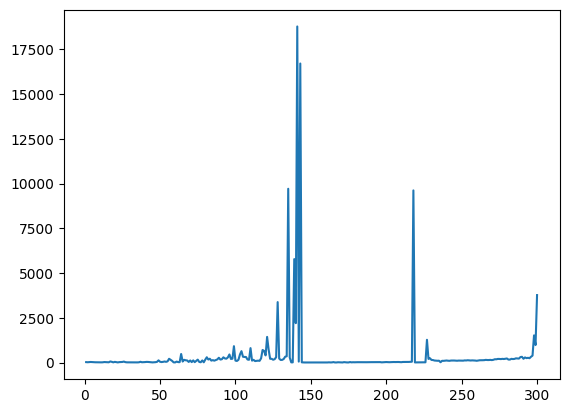

In [103]:
N = 20
batch_size = 5
n_epochs = 4
alpha = 0.0003
agent = Agent(n_actions=env.action_space.n, input_dims=env.observation_space.shape, batch_size=batch_size, alpha=alpha, n_epochs=n_epochs)

n_games = 300

best_score = -1000
score_history = []

learn_iters = 0
avg_score = 0
n_steps = 0

for i in range(n_games):
    (observation, _) = env.reset()
    done = False
    score = 0
    while not done:
        action, prob, val = agent.choose_action(observation)
        observation_, reward, done, _, info = env.step(action)
        n_steps += 1
        score += reward
        agent.remember(observation, action, prob, val, reward, done)
        if n_steps % N == 0:
            agent.learn()
            learn_iters += 1
        observation = observation_
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])

    if avg_score > best_score:
        best_score = avg_score
        agent.save_models()

    print('episode', i, 'score %.1f' % score,'avg score %.1f' % avg_score, 'time_steps', n_steps, 'learning_steps', learn_iters)
x = [i + 1 for i in range(len(score_history))]
plt.plot(x, score_history)